# Compare all of CPU/GPU/Multi-GPU DataFrame
---

I am an NVIDIA DLI Amabbassador for the "Fundamentals of Accelerated Data Science" and "Accelerating Data Engineering Pipelines" courses, representing South Korea at the Catholic University of Korea.

Currently, I am studying [RAPIDS](https://rapids.ai/) with [Modulabs](https://modulabs.co.kr/). As part of my work, I am creating tutorials to compare the performance of CPU, GPU, and multi-GPU systems.


This [notebook](https://www.kaggle.com/code/cdeotte/compare-cpu-dataframes-to-gpu-dataframes) originally compared only single CPU and GPU performance. I have modified the code to extend the comparisons across most of the RAPIDS ecosystem, providing a broader comparison than the original notebook.

## 1. Import and Check Version of Libraries and CPU/GPU version
---

We are using Pandas Polars, RAPIDS cuDF, Dask, and Dask cuDF

In [1]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    "cudf-cu12==24.10.*" "dask-cudf-cu12==24.10.*" "cuml-cu12==24.10.*" \
    "cugraph-cu12==24.10.*" "nx-cugraph-cu12==24.10.*" "cuspatial-cu12==24.10.*" \
    "cuproj-cu12==24.10.*" "cuxfilter-cu12==24.10.*" "cucim-cu12==24.10.*" \
    "pylibraft-cu12==24.10.*" "raft-dask-cu12==24.10.*" "cuvs-cu12==24.10.*" \
    "nx-cugraph-cu12==24.10.*" "cudf-polars-cu12"

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 919.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 105.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 56.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 101.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.6/836.6 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
import time
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import platform

import cupy as cp

import dask
import pandas as pd, polars as pl, cudf, dask.dataframe as ddf,dask_cudf as dd
import numpy as np, time
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

head_line  = f"|{'='*39}|"
subhead_line = f"|{'='*19}+{'='*19}|"
split_line = f"+{'-'*19}+{'-'*19}+"
blank_line = f"|{' '*39}|"

print(head_line)
print(f"|{'CPU/GPU Compare Code':^39}|")
print(blank_line)
print(f'|{"Python " +platform.python_version():>39}|')
print(head_line)

print(f"|{'Module':>19}|{'version':>19}|")
print(subhead_line)


print(f"|{'Pandas':>19}|{pd.__version__:>19}|")
print(split_line)

print(f"|{'Polars':>19}|{pl.__version__:>19}|")
print(split_line)

print(f"|{'cuDF':>19}|{cudf.__version__:>19}|")
print(split_line)

print(f"|{'DASK':>19}|{dask.__version__:>19}|")
print(split_line)

print(f"|{'DASK GPU':>19}|{dd.__version__:>19}|")
print(head_line)


|=======================================|
|         CPU/GPU Compare Code          |
|                                       |
|                         Python 3.10.12|
|=======================================|
|             Module|            version|
|===================+===================|
|             Pandas|              2.2.2|
+-------------------+-------------------+
|             Polars|              1.8.2|
+-------------------+-------------------+
|               cuDF|           24.10.01|
+-------------------+-------------------+
|               DASK|           2024.9.0|
+-------------------+-------------------+
|           DASK GPU|           24.10.01|
|=======================================|


## 2. Displaying CPU/GPU info
---

In [3]:
!lscpu | head -n 8

Architecture:                         x86_64
CPU op-mode(s):                       32-bit, 64-bit
Address sizes:                        46 bits physical, 48 bits virtual
Byte Order:                           Little Endian
CPU(s):                               2
On-line CPU(s) list:                  0,1
Vendor ID:                            GenuineIntel
Model name:                           Intel(R) Xeon(R) CPU @ 2.00GHz


In [4]:
!nvidia-smi | head -n 16

Wed Dec 18 05:47:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 2. Make Test Dataset
---

We create massive datasets to perform comparisons, especially focusing on the differences between the .csv and .parquet file formats.

The .parquet format is generally more efficient for data storage because it supports compression, which significantly reduces file size. Additionally, .parquet stores data in a columnar format, making it particularly well-suited for tasks such as data aggregation.

However, .parquet files are immutable and not human-readable, which can be a limitation depending on your use case.

When selecting a data file format, it is important to consider the nature of your tasks. For example, if you are performing feature engineering, the .parquet format may offer better efficiency due to its columnar storage structure and compression capabilities.

In [5]:
import os

PATH = os.path.join("..", "data", "toy")
os.makedirs(PATH, exist_ok=True)

In [6]:
import random, string

def make_dataframes(seed=0, n_rows=200_000_00, verbose=False):

    cp.random.seed(seed)
    data = {
        'col1': cp.random.rand(n_rows).astype('float32'),
        'col2': cp.random.rand(n_rows).astype('float32'),
        'col3': cp.random.randint(0, 10, n_rows).astype('int'),
        'col4': cp.random.rand(n_rows).astype('float32'),
    }

    #Make Data Frame
    df_pandas = cudf.DataFrame(data)
    return df_pandas

In [7]:
make_dataframes(n_rows=1_000_00).to_csv(os.path.join(PATH, "numbers.csv"))
make_dataframes(n_rows=10_000_00).to_csv(os.path.join(PATH, "numbers2.csv"))
make_dataframes(n_rows=100_000_00).to_csv(os.path.join(PATH, "numbers3.csv"))
make_dataframes(n_rows=200_000_00).to_csv(os.path.join(PATH, "numbers4.csv"))

## 3. Make Timer and Plot
---


## 4. Read dataframe test
---

In this test, we utilize .read_csv()

Generally, the .parquet format demonstrates more efficient reading performance on GPUs.

In [8]:
def pandas_read_csv(path):
    return pd.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])

def cudf_read_csv(path):
    return cudf.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])

def polars_read_csv(path):
    pdf = pl.scan_csv(path).select(['col1', 'col2', 'col3', 'col4'])
    return pdf.collect().lazy()

def polars_gpu_read_csv(path):
    pdf = pl.scan_csv(path).select(['col1', 'col2', 'col3', 'col4'])
    return pdf.collect(engine="gpu").lazy()

def dask_read_csv(path):
    cdf = ddf.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])
    return cdf.persist()

def dask_gpu_read_csv(path):
    gdf = dd.read_csv(path, usecols=['col1', 'col2', 'col3', 'col4'])
    return gdf.persist()


## 5. join dataframe test

In [9]:
def pandas_join(df):
    return df.merge(df, on='col4')

def cudf_join(df):
    return df.merge(df, on='col4')

def polars_join(df):
    pdf = (df
           .join(df, on='col4')
      )
    pdf.collect()

def polars_gpu_join(df):
    pdf = (df
           .join(df, on='col4')
      )
    pdf.collect(engine="gpu")

def dask_join(df):
    cdf = df.merge(df, on='col4').compute()

def dask_gpu_join(df):
    gdf = df.merge(df, on='col4').compute()

## 6.Groupby_mean

In [10]:
def pandas_groupby_mean(df):
    return df.groupby('col3')['col1'].mean()

def cudf_groupby_mean(df):
    df.groupby('col3')['col1'].mean()

def polars_groupby_mean(df):
    pdf = (df
           .group_by('col3')
           .agg(pl.col('col1'))
           .mean()
      )
    pdf.collect()

def polars_gpu_groupby_mean(df):
    pdf = (df
           .group_by('col3')
           .agg(pl.col('col1'))
           .mean()
      )
    pdf.collect(engine="gpu")

def dask_groupby_mean(df):
    df.compute().groupby('col3')['col1'].mean()

def dask_gpu_groupby_mean(df):
    df.compute().groupby('col3')['col1'].mean()

## 7.Filter Test

In [11]:
def pandas_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ]

def cudf_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ]

def polars_filter(df):
    pdf = (df
           .filter(pl.col("col1") > 0.5)
           .filter(pl.col("col2") > 0.5)
      )
    pdf.collect()

def polars_gpu_filter(df):
    pdf = (df
           .filter(pl.col("col1") > 0.5)
           .filter(pl.col("col2") > 0.5)
      )
    pdf.collect(engine="gpu")

def dask_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ].compute()

def dask_gpu_filter(df):
    df[ (df['col1'] > 0.5) & (df['col2'] > 0.5) ].compute()

# 8. Sort Test

In [12]:
def pandas_sort(df):
    df.sort_values(["col1"])

def cudf_sort(df):
    df.sort_values(["col1"])

def polars_sort(df):
    pdf = (df
           .sort("col1")
      )
    pdf.collect()

def polars_gpu_sort(df):
    pdf = (df
           .sort("col1")
      )
    pdf.collect(engine="gpu")

def dask_sort(df):
    df.sort_values(["col1"]).compute()

def dask_gpu_sort(df):
    df.sort_values(["col1"]).compute()

## Main Code
---

In [13]:
def plot_graph(data, n_rows):
    global test_libs, test_func
    num_groups = len(data)
    bar_width = 0.25
    space_between_groups = 1
    x_pos = np.arange(num_groups) * (bar_width * int(num_groups//2 + 1)+ space_between_groups)  # X positions for groups
    fig, ax = plt.subplots(figsize=(12, 3))
    for i,libs in enumerate(test_libs[:-1]):
        label = f"cuDF vs {libs}"
        bars = ax.bar(x_pos + i * bar_width, [ row[i]/row[-1] for row in data], width=bar_width, label=label)

        for j,bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + (bar.get_width() / 2), height, f'{height:.1f}x',
                    ha='center', va='bottom', fontsize=10)

    ax.set_ylabel('Speed Up Factor')
    ax.set_title(f'RAPIDS cuDF Speed Up versus Pandas and Polars (with {n_rows:.1e} rows dataframe)')
    ax.set_xticks(x_pos + int(num_groups//2) * bar_width)
    ax.set_xticklabels([f"{t}" for t in test_funcs[:int(num_groups)]])
    ax.legend()
    plt.tight_layout()
    plt.show()

In [14]:
ITERS = 10
all_result = []
test_libs = ['pandas', 'polars', 'polars_gpu', 'dask', 'dask_gpu','cudf']
test_funcs = ['read_csv', 'join', 'groupby_mean', 'filter', 'sort' ]

def make_results(data_path):
    results      = []
    for test_name in test_libs:

        test_results = []
        ##################
        # Read csv test
        ##################
        func = globals()[f"{test_name}_read_csv"]
        start   = time.time()      # Calc Start
        for i in range(ITERS):
            rf = func(data_path)

        end     = time.time()      # Calc End..
        elapsed = (end-start)/ITERS
        test_results.append(elapsed)

        print(f"Now {test_name} testing... Average Data Read time : {elapsed:.4f}")
        ###################
        # Other Function test
        ###################
        for test_func in test_funcs[1:]:
            func = globals()[f"{test_name}_{test_func}"]
            start   = time.time()      # Calc Start
            for i in range(ITERS):
                func(rf)
            end     = time.time()      # Calc End..
            elapsed = (end-start)/ITERS
            test_results.append(elapsed)

            print(f"Now {test_func} testing... Average Data Read time : {elapsed:.4f}")

        results.append(test_results)
    results = np.array(results).T
    return results

# Test 1_000_00 Sample

Now pandas testing... Average Data Read time : 0.1126
Now join testing... Average Data Read time : 0.0377
Now groupby_mean testing... Average Data Read time : 0.0054
Now filter testing... Average Data Read time : 0.0029
Now sort testing... Average Data Read time : 0.0088
Now polars testing... Average Data Read time : 0.0443
Now join testing... Average Data Read time : 0.0308
Now groupby_mean testing... Average Data Read time : 0.0039
Now filter testing... Average Data Read time : 0.0018
Now sort testing... Average Data Read time : 0.0208
Now polars_gpu testing... Average Data Read time : 0.0318
Now join testing... Average Data Read time : 0.0173
Now groupby_mean testing... Average Data Read time : 0.0032
Now filter testing... Average Data Read time : 0.0126
Now sort testing... Average Data Read time : 0.0253
Now dask testing... Average Data Read time : 0.2703
Now join testing... Average Data Read time : 0.0798
Now groupby_mean testing... Average Data Read time : 0.0059
Now filter testi

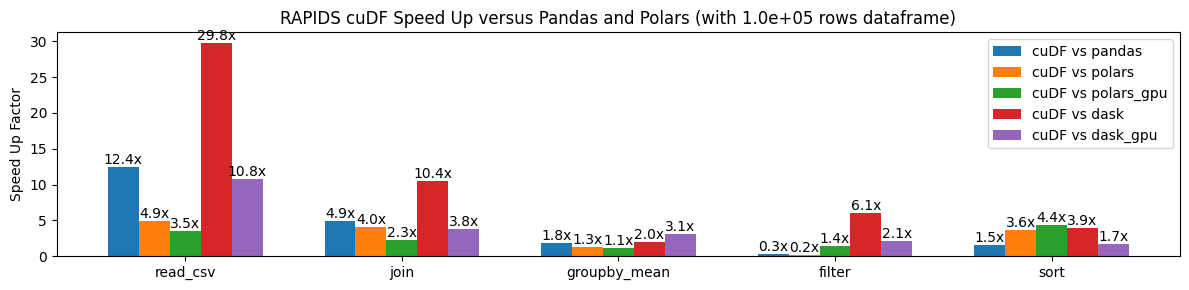

In [15]:
data_path = os.path.join(PATH, "numbers.csv")
results = make_results(data_path)
plot_graph(results, 1_000_00)
all_result.append(results)

# Test 10_000_00 Sample

Now pandas testing... Average Data Read time : 0.5295
Now join testing... Average Data Read time : 0.2688
Now groupby_mean testing... Average Data Read time : 0.0277
Now filter testing... Average Data Read time : 0.0113
Now sort testing... Average Data Read time : 0.1367
Now polars testing... Average Data Read time : 0.2255
Now join testing... Average Data Read time : 0.1643
Now groupby_mean testing... Average Data Read time : 0.0065
Now filter testing... Average Data Read time : 0.0037
Now sort testing... Average Data Read time : 0.1282
Now polars_gpu testing... Average Data Read time : 0.0382
Now join testing... Average Data Read time : 0.0289
Now groupby_mean testing... Average Data Read time : 0.0069
Now filter testing... Average Data Read time : 0.0128
Now sort testing... Average Data Read time : 0.0224
Now dask testing... Average Data Read time : 0.5558
Now join testing... Average Data Read time : 0.3414
Now groupby_mean testing... Average Data Read time : 0.0175
Now filter testi

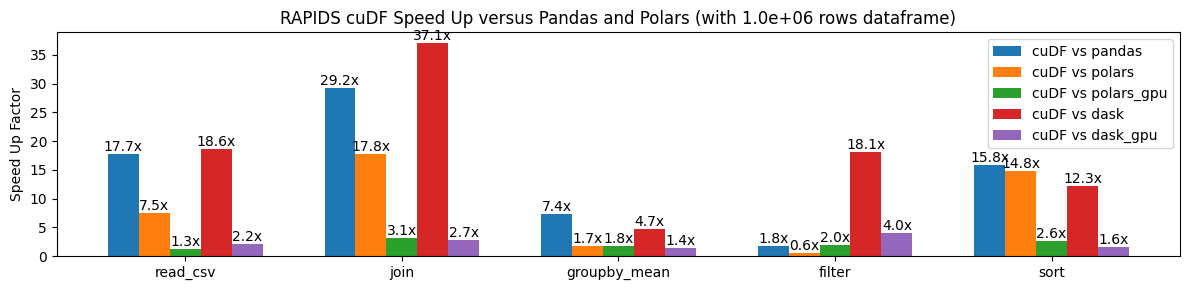

In [16]:
data_path = os.path.join(PATH, "numbers2.csv")
results = make_results(data_path)
plot_graph(results, 10_000_00)
all_result.append(results)

# Test 100_00_000 Sample

Now pandas testing... Average Data Read time : 5.1034
Now join testing... Average Data Read time : 7.8609
Now groupby_mean testing... Average Data Read time : 0.1934
Now filter testing... Average Data Read time : 0.1386
Now sort testing... Average Data Read time : 2.4348
Now polars testing... Average Data Read time : 1.6496
Now join testing... Average Data Read time : 4.0737
Now groupby_mean testing... Average Data Read time : 0.0651
Now filter testing... Average Data Read time : 0.0898
Now sort testing... Average Data Read time : 2.3311
Now polars_gpu testing... Average Data Read time : 0.4869
Now join testing... Average Data Read time : 0.7757
Now groupby_mean testing... Average Data Read time : 0.0667
Now filter testing... Average Data Read time : 0.1445
Now sort testing... Average Data Read time : 0.4734
Now dask testing... Average Data Read time : 5.3941
Now join testing... Average Data Read time : 5.0702
Now groupby_mean testing... Average Data Read time : 0.4036
Now filter testi

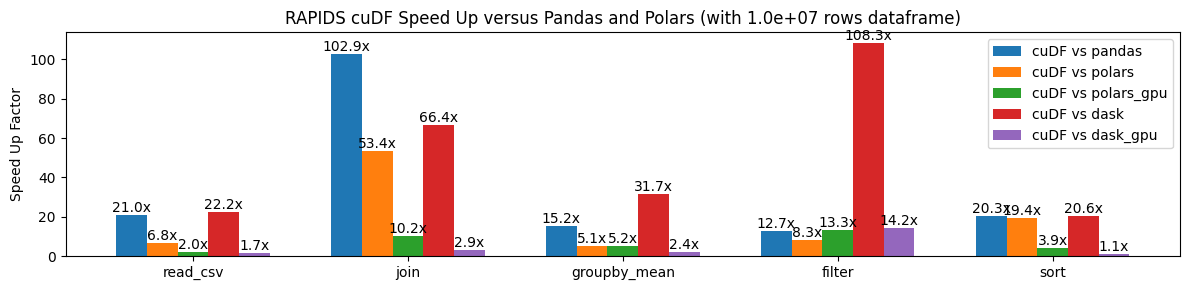

In [17]:
data_path = os.path.join(PATH, "numbers3.csv")
results = make_results(data_path)
plot_graph(results, 100_000_00)
all_result.append(results)

# Test  200_00_000 Sample

Now pandas testing... Average Data Read time : 10.3153
Now join testing... Average Data Read time : 23.9822
Now groupby_mean testing... Average Data Read time : 0.3798
Now filter testing... Average Data Read time : 0.2581
Now sort testing... Average Data Read time : 5.1018
Now polars testing... Average Data Read time : 3.6048
Now join testing... Average Data Read time : 11.1693
Now groupby_mean testing... Average Data Read time : 0.1327
Now filter testing... Average Data Read time : 0.1557
Now sort testing... Average Data Read time : 5.2220
Now polars_gpu testing... Average Data Read time : 1.0219
Now join testing... Average Data Read time : 1.9786
Now groupby_mean testing... Average Data Read time : 0.1348
Now filter testing... Average Data Read time : 0.3039
Now sort testing... Average Data Read time : 0.9341
Now dask testing... Average Data Read time : 10.9842
Now join testing... Average Data Read time : 11.5277
Now groupby_mean testing... Average Data Read time : 0.6259
Now filter 

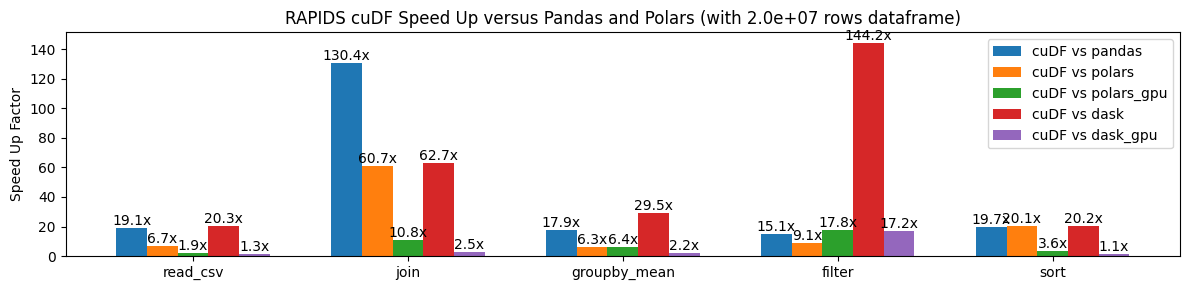

In [18]:
data_path = os.path.join(PATH, "numbers4.csv")
results = make_results(data_path)
plot_graph(results, 200_000_00)
all_result.append(results)

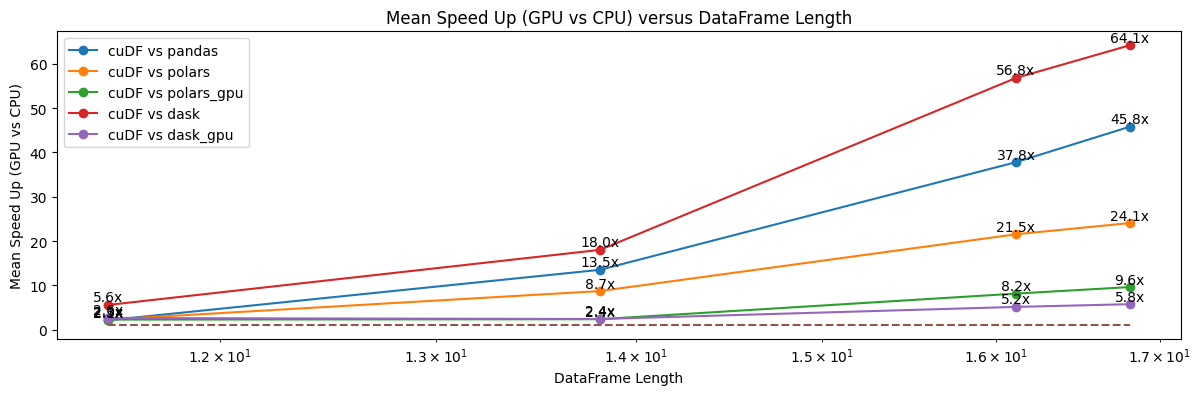

In [50]:
# %matplotlib inline
x = np.log(np.array([1_000_00, 10_000_00, 100_000_00, 200_000_00]))
result_mean = np.mean((np.array(all_result)[..., :5] / np.array(all_result)[..., -1:]).transpose(0, 2, 1)[..., 1:], axis=-1).T

plt.figure(figsize=(14.5, 4))

plt.title("Mean Speed Up (GPU vs CPU) versus DataFrame Length")
plt.xlabel("DataFrame Length")
plt.ylabel("Mean Speed Up (GPU vs CPU)")
plt.xticks(x)
plt.xscale('log')
for r, l in zip(result_mean, test_libs[:-1]):
  label = f"cuDF vs {l}"
  plt.plot(x, r, '-o', label=label)

  for xp, yp in zip(x, r):
    plt.text(xp, yp + 0.8, f"{yp:.1f}x", ha='center')

plt.plot([x[0], x[-1]], [1, 1], '--')
plt.gca().xaxis.set_major_formatter(FuncFormatter(lambda val, pos: f'{np.exp(val):.1e}'))
plt.legend()